<img src="https://upload.wikimedia.org/wikipedia/commons/f/f2/Sphere5tesselation.gif" alt="Tiling of the sphere by spherical triangles"></img>

# Spherical Polygons and Areas

---

## Overview
In this notebook, we will calculate how to use spherical polygons on a unit sphere to determine areas and perimeters.

- Calculate area and permieter of quadrilateral patch on a unit sphere
- Determine if a given point is within a spherical polygon
- Mean center of spherical polygon

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Numpy](https://foundations.projectpythia.org/core/numpy/) | Necessary | Used to work with large arrays |
| [Pandas](https://foundations.projectpythia.org/core/pandas) | Necessary | Used to read in and organize data (in particular dataframes) |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy) | Helpful | Will be used for adding maps to plotting |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib/) | Helpful | Will be used for plotting |

- **Time to learn**: 40 minutes

---

## Imports

- Import Packages
- Setup location dataframe with coordinates

In [2]:
import pandas as pd       # reading in data for location information from text file
import numpy as np        # working with arrays, vectors, cross/dot products, and radians

from pyproj import Geod   # working with the Earth as an ellipsod (WGS-84)

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import matplotlib.pyplot as plt                        # plotting a graph
from cartopy import crs as ccrs, feature as cfeature   # plotting a world map

In [3]:
# Get all Coordinates for Locations
location_df = pd.read_csv("../location_full_coords.txt")
location_df = location_df.rename(columns=lambda x: x.strip()) # strip excess white space from column names and values
location_df.head()

,name,latitude,longitude,cart_x,cart_y,cart_z,rho,theta,phi,polar_x,polar_y,polar_z
0,arecibo,18.3441,-66.7527,0.374643,-0.872119,0.314723,1.0,-1.165054,1.250631,-5.562495e+06,2.389526e+06,2.007347e+06
1,boulder,40.0150,-105.2705,-0.201714,-0.738835,0.642988,1.0,1.304276,0.872403,-4.712394e+06,-1.286558e+06,4.101066e+06
2,boston,42.3601,-71.0589,0.239852,-0.698914,0.673788,1.0,-1.240212,0.831473,-4.457769e+06,1.529809e+06,4.297512e+06
3,redwoods,41.4017,-124.0417,-0.419898,-0.621549,0.661334,1.0,0.976657,0.848200,-3.964322e+06,-2.678169e+06,4.218080e+06
4,houston,29.5518,-95.0982,-0.077303,-0.866469,0.493210,1.0,1.481816,1.055020,-5.526456e+06,-4.930480e+05,3.145762e+06


In [4]:
location_df.index = location_df["name"]

## Area and Perimeter of quadrilateral patch

We can make use of the `pyproj` Python package to calculate the area and perimeter of a patch formed by a list of latitude and longitude coordinates for an ellipsoid or a unit sphere.

In [5]:
def area_of_polygon_ellps(poly_pts=None):
    geod = Geod(ellps="WGS84")
    longitudes = [location_df.loc[pt, "longitude"] for pt in poly_pts]
    latitudes = [location_df.loc[pt, "latitude"] for pt in poly_pts]
    poly_area_m, poly_perimeter_m = geod.polygon_area_perimeter(longitudes, latitudes)
    return abs(poly_area_m) * 1e-6, poly_perimeter_m/1000 # km^2 and km

def area_of_polygon_unit_sphere(poly_pts=None):
    geod = Geod(ellps="sphere") # 'sphere': {'a': 6370997.0, 'b': 6370997.0, 'description': 'Normal Sphere (r=6370997)'
    longitudes = [location_df.loc[pt, "longitude"] for pt in poly_pts]
    latitudes = [location_df.loc[pt, "latitude"] for pt in poly_pts]
    poly_area_m, poly_perimeter_m = geod.polygon_area_perimeter(longitudes, latitudes)
    return abs(poly_area_m) * 1e-6, poly_perimeter_m/1000 # km^2 and km

Let's compare how area and perimeter vary based on whether you use an ellpsoid like  WGS-84 and a unit sphere. The changes will become more pronounced as you move further towards the poles.

In [6]:
area_ellps, perimeter_ellps = area_of_polygon_ellps(["boulder", "boston",
                                             "arecibo", "houston"])
area_us, perimeter_us = area_of_polygon_unit_sphere(["boulder", "boston",
                                             "arecibo", "houston"])
print(f"Area Ellipsoid   = {area_ellps} km^2")
print(f"Area Unit Sphere = {area_us} km^2")
print(f"Perimeter Ellipsoid = {perimeter_ellps} km")
print(f"Perimeter Unit SPhere = {perimeter_us} km")
print(f"Roughly {(area_ellps/509600000)*100:.2f}% of the Earth's Surface")
print(f"Roughly {(area_us/509600000)*100:.2f}% of the Earth's Surface")

Area Ellipsoid   = 5342585.6476998255 km^2
Area Unit Sphere = 5344606.94796931 km^2
Perimeter Ellipsoid = 10171.738963248145 km
Perimeter Unit SPhere = 10170.504728302833 km
Roughly 1.05% of the Earth's Surface
Roughly 1.05% of the Earth's Surface


### Plot Area of Quadrilateral Patch

Let's see what spherical polygons looks like on a world map!

In [7]:
def plot_area(pt_lst=None,
                   lon_west=-180, lon_east=180,
                   lat_south=-90, lat_north=90):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.STATES, edgecolor="black")

   # plot points
    longitudes = [location_df.loc[x, "longitude"] for x in pt_lst] # longitude
    latitudes = [location_df.loc[y, "latitude"] for y in pt_lst] # latitude
    plt.scatter(longitudes, latitudes, s=100, c="red")
    plt.fill(longitudes, latitudes, alpha=0.5)

    # determine the area and perimeter
    area_ellps, perimeter_ellps = area_of_polygon_ellps(pt_lst)
    area_us, perimeter_us = area_of_polygon_unit_sphere(pt_lst)
    print(f"Ellipsoid Area   = {area_ellps} km^2")
    print(f"Unit Sphere Area = {area_us} km^2")
    plt.title(f"Roughly {(area_ellps/509600000)*100:.2f}% ({(area_us/509600000)*100:.2f}%) of the Earth's Surface")
    plt.show()

Ellipsoid Area   = 21872449.378265787 km^2
Unit Sphere Area = 21896220.663299154 km^2


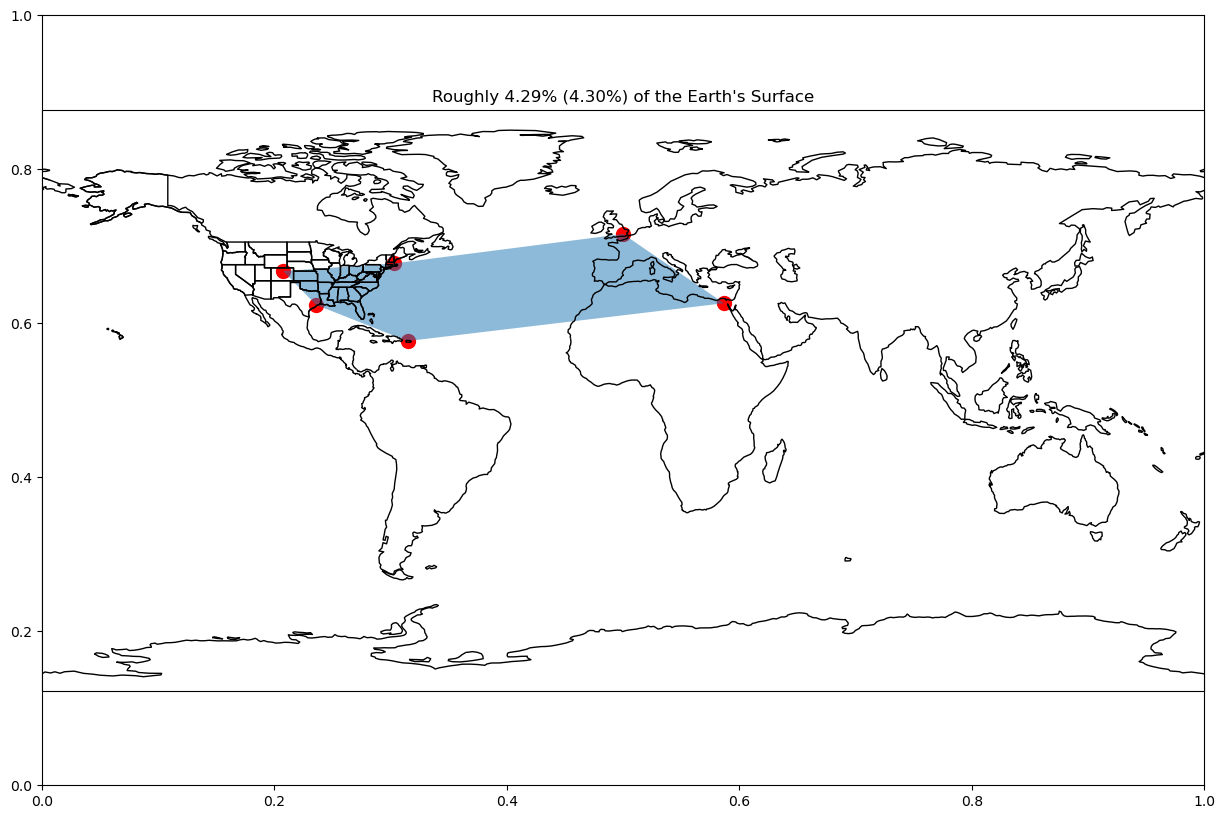

In [8]:
plot_area(["boulder", "boston", "greenwich", "cairo", "arecibo", "houston"])

Ellipsoid Area   = 3150946.426714995 km^2
Unit Sphere Area = 3149017.3086414044 km^2


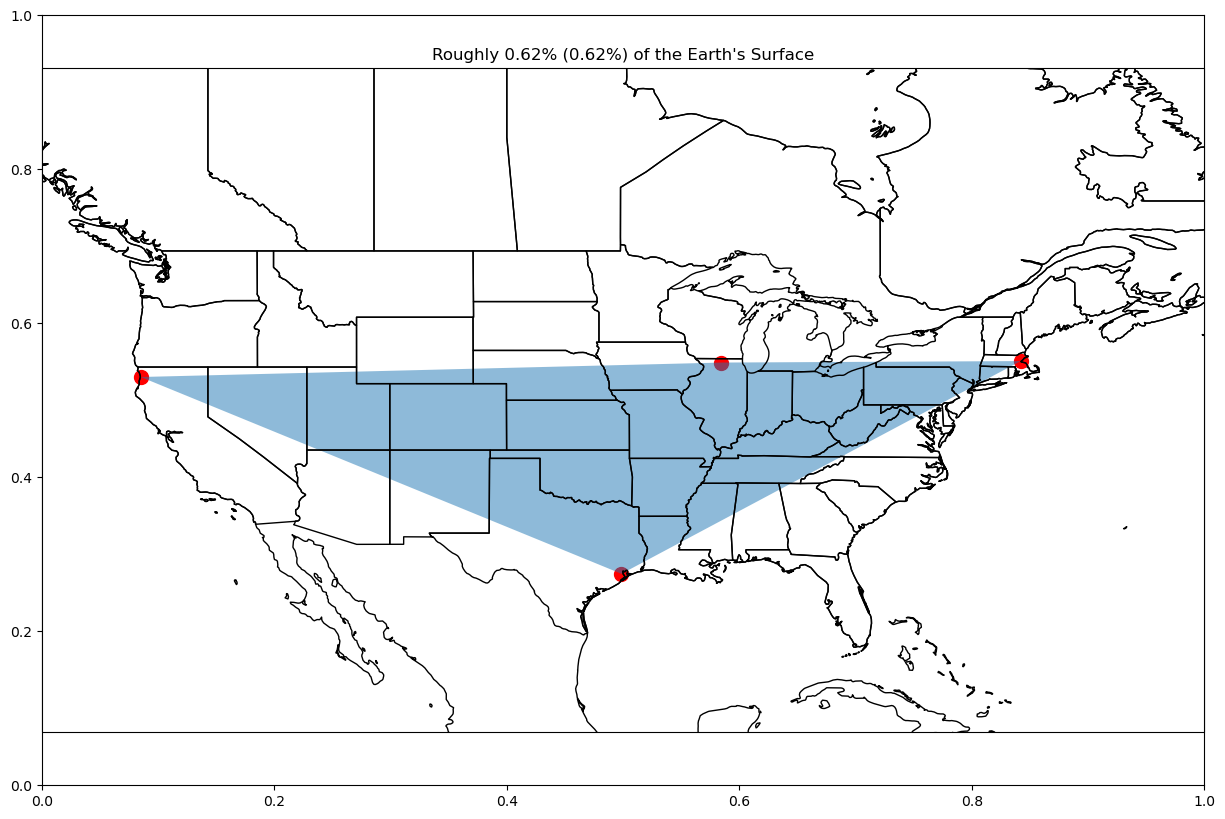

In [9]:
plot_area(["redwoods", "rockford", "boston", "houston",], -130, -60, 20, 60)

Ellipsoid Area   = 3788155.432965353 km^2
Unit Sphere Area = 3782548.632737316 km^2


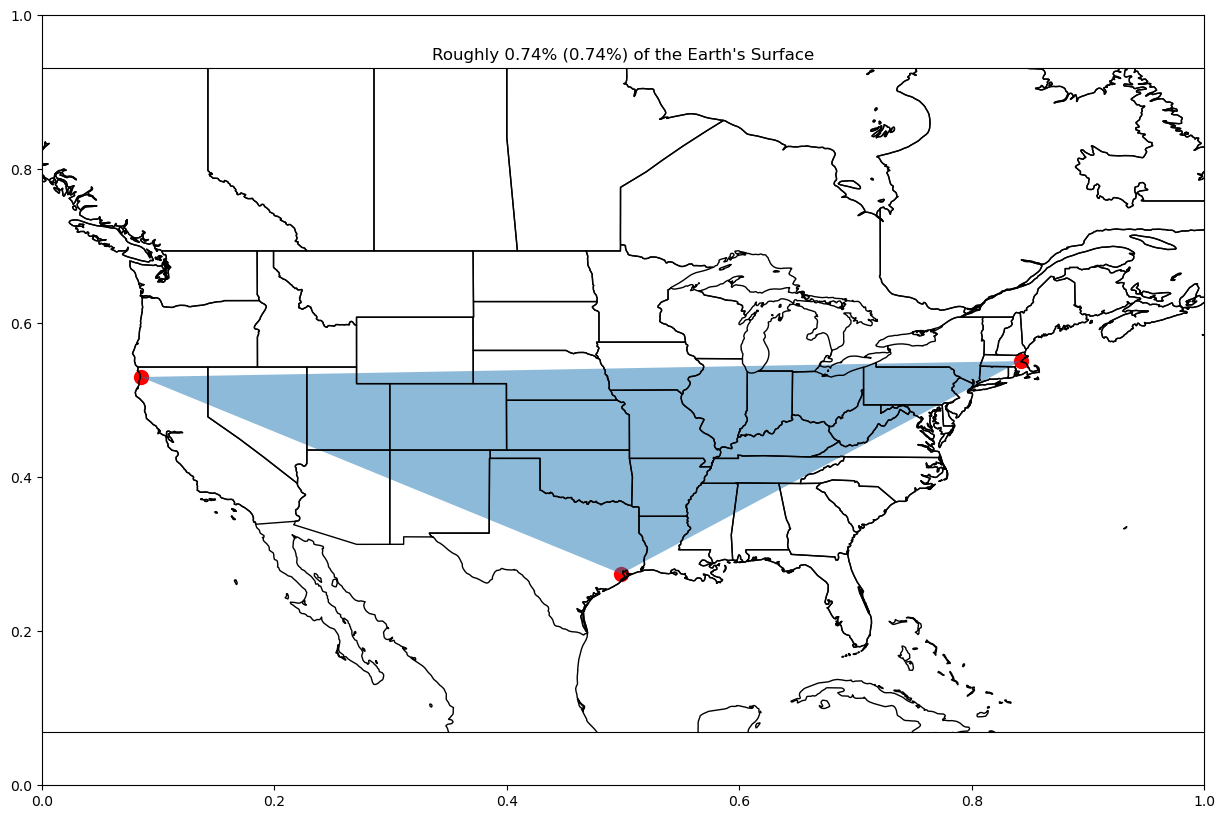

In [10]:
plot_area(["redwoods", "boston", "houston"], -130, -60, 20, 60)

> [!IMPORTANT]
> Make sure that the points that form the polygon are in a clockwise or counterclockwise order. Otherwise, the polygon formed will have overlapping portions and the area will not be valid

Ellipsoid Area   = 914381.1786067598 km^2
Unit Sphere Area = 954445.989927043 km^2


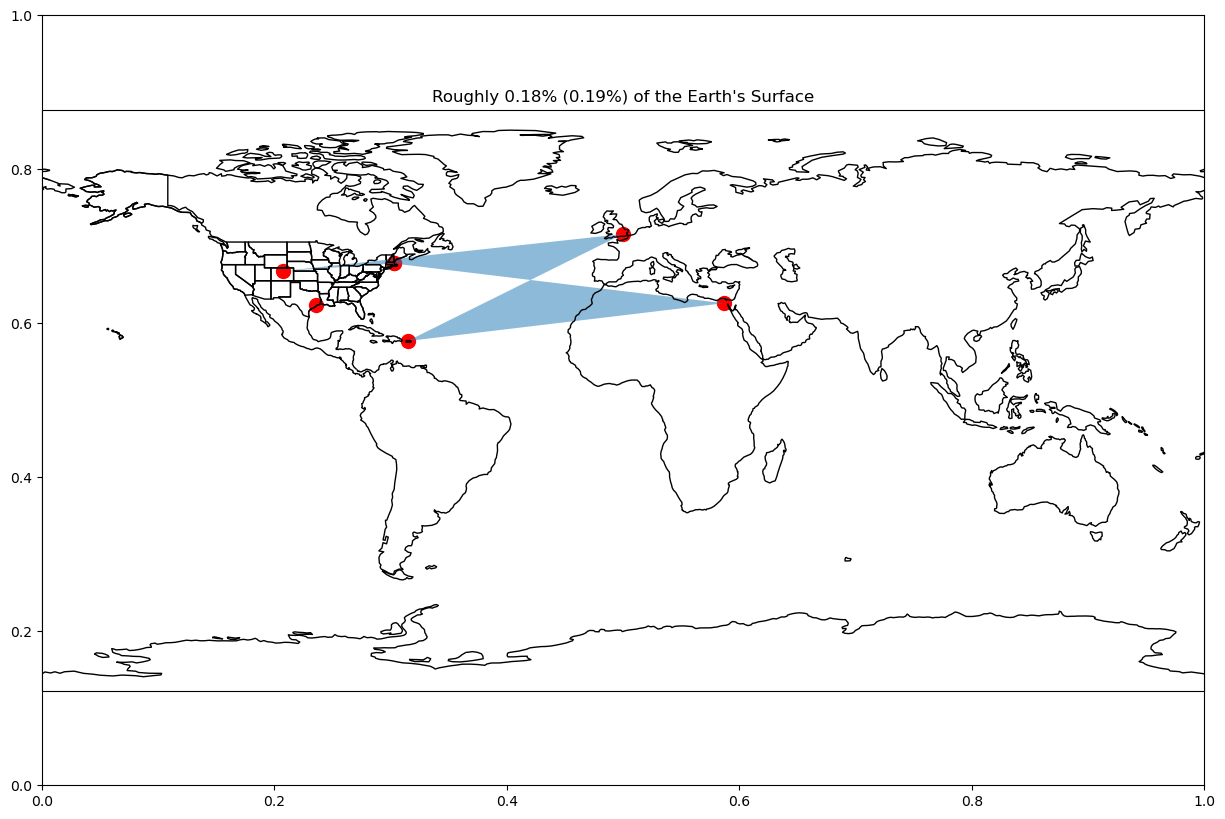

In [11]:
# For example: here is a list of unordered points
plot_area(["boulder", "boston", "houston", "boston", "cairo", "arecibo", "greenwich"])

## Determine if a given point is within a spherical polygon

Now that we have a spherical polygon, how can be determine if a new point lies within the area of the polygon? The `shapely` Python package makes this quite easy, let's give it a shot!

In [18]:
def polygon_contains_points(pt_lst=None, polygon_pts=None):
    longitudes = [location_df.loc[pt, "longitude"] for pt in polygon_pts]
    latitudes = [location_df.loc[pt, "latitude"] for pt in polygon_pts]
    lat_lon_coords = tuple(zip(longitudes, latitudes))
    # setup polygon
    polygon = Polygon(lat_lon_coords)
    # check if new point lies within the polygon
    contains = np.vectorize(lambda pt: polygon.contains(Point((location_df.loc[pt, "longitude"],
                                                               location_df.loc[pt, "latitude"]))))
    contained_by_polygon = contains(np.array(pt_lst))
    return contained_by_polygon

In [19]:
polygon_contains_points(["boulder"], ["redwoods", "boston", "houston"])

array([ True])

### Plot and See if New Point within Polygon

On a map, it can be fairly intuitive to see if a point lies within a polygon or not. Let's give it a shot! 

In [20]:
def plot_polygon_pts(pt_lst=None, polygon_pts=None,
                   lon_west=-180, lon_east=180,
                   lat_south=-90, lat_north=90):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.STATES, edgecolor="black")

    # plot polygon points
    longitudes = [location_df.loc[x, "longitude"] for x in polygon_pts] # longitude
    latitudes = [location_df.loc[y, "latitude"] for y in polygon_pts] # latitude
    plt.scatter(longitudes, latitudes, s=50, c="blue")
    plt.fill(longitudes, latitudes, alpha=0.5)

    # plot check points
    pt_lst = np.array(pt_lst)
    contains_pts = polygon_contains_points(pt_lst, polygon_pts)
    longitudes = [location_df.loc[x, "longitude"] for x in pt_lst[contains_pts]] # longitude
    latitudes = [location_df.loc[y, "latitude"] for y in pt_lst[contains_pts]] # latitude
    plt.scatter(longitudes, latitudes, s=100, c="green", label="Within Polygon")
    longitudes = [location_df.loc[x, "longitude"] for x in pt_lst[~contains_pts]] # longitude
    latitudes = [location_df.loc[y, "latitude"] for y in pt_lst[~contains_pts]] # latitude
    plt.scatter(longitudes, latitudes, s=100, c="red", label="Not within Polygon")

    plt.legend(loc="lower left")
    plt.title(f"Points contained within polygon = {pt_lst[contains_pts]}, not contained = {pt_lst[~contains_pts]}")
    plt.show()

In [21]:
polygon_contains_points(["boulder"], ["redwoods", "boston", "houston"])

array([ True])

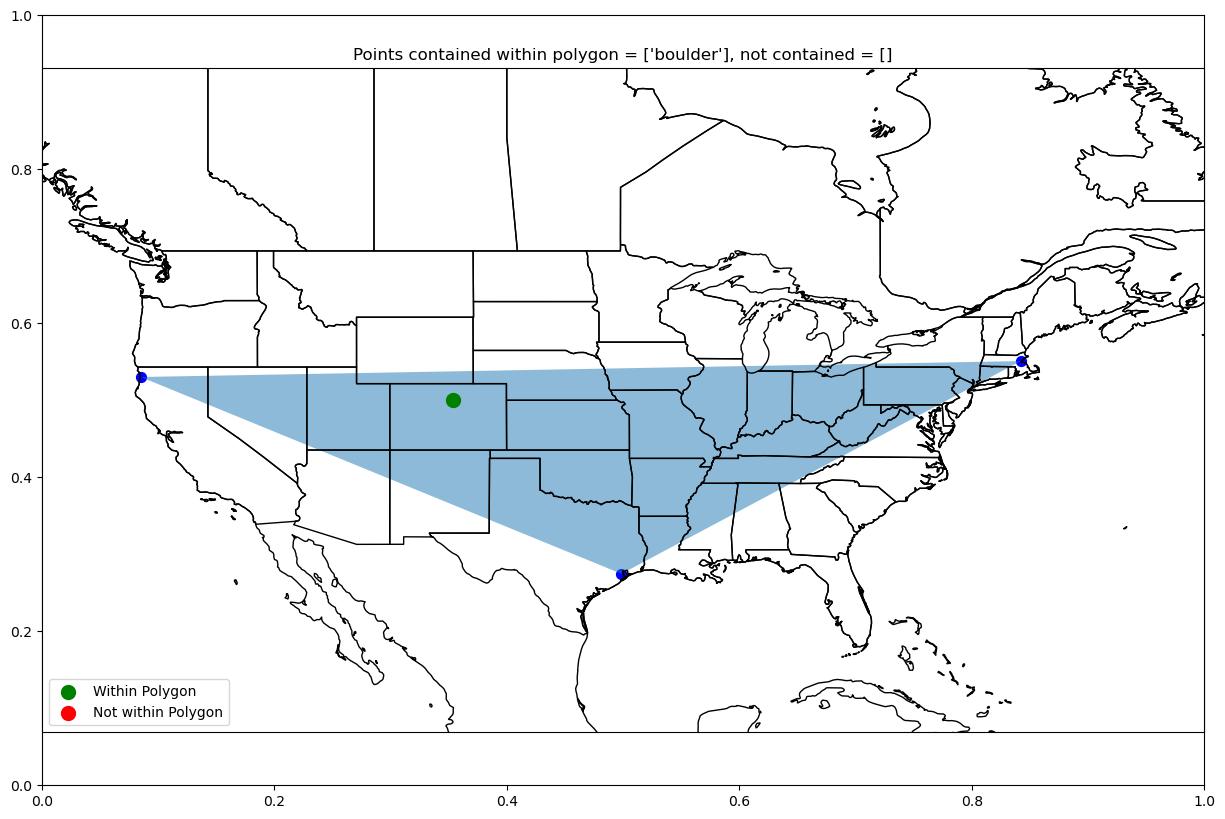

In [22]:
plot_polygon_pts(["boulder"], ["redwoods", "boston", "houston"],
               -130, -60, 20, 60)

In [23]:
polygon_contains_points(["cape canaveral"], ["redwoods", "boston", "houston"])

array([False])

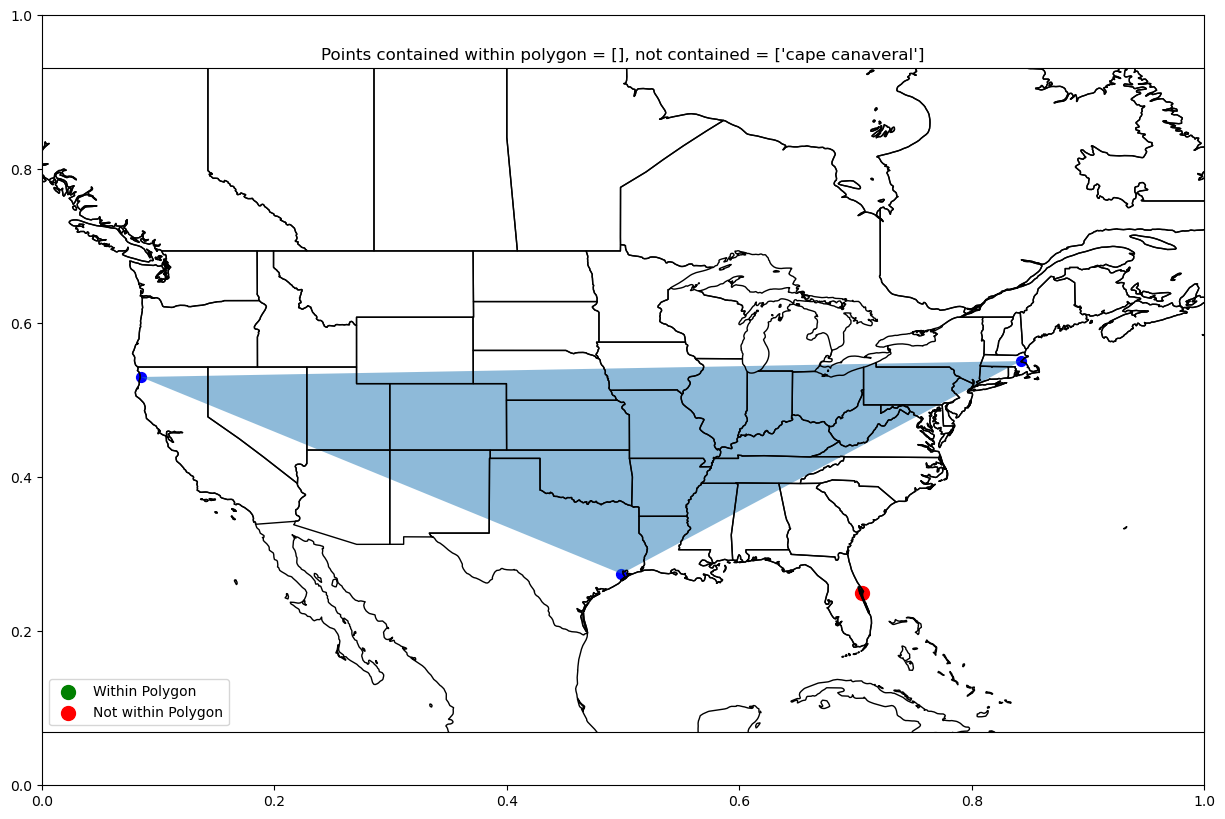

In [24]:
plot_polygon_pts(["cape canaveral"], ["redwoods", "boston", "houston"],
               -130, -60, 20, 60)

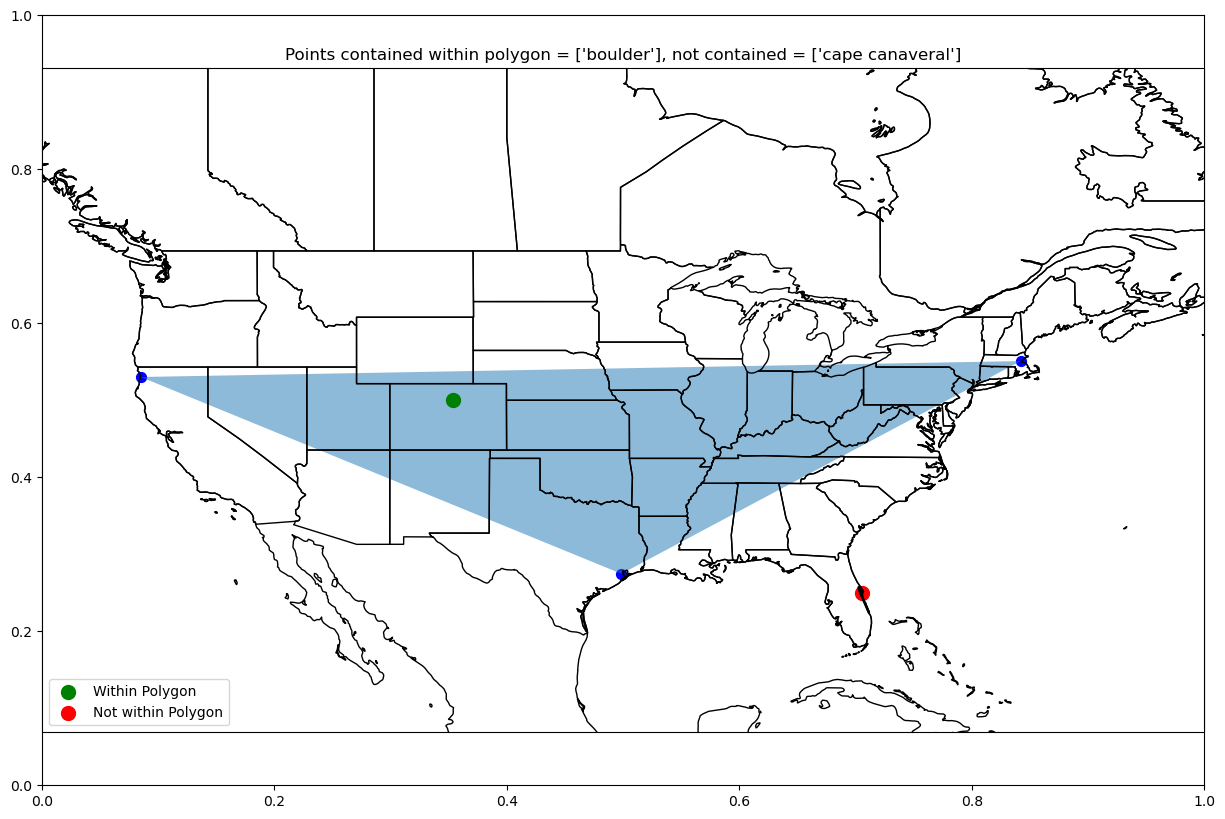

In [25]:
plot_polygon_pts(["boulder", "cape canaveral"], ["redwoods", "boston", "houston"],
               -130, -60, 20, 60)

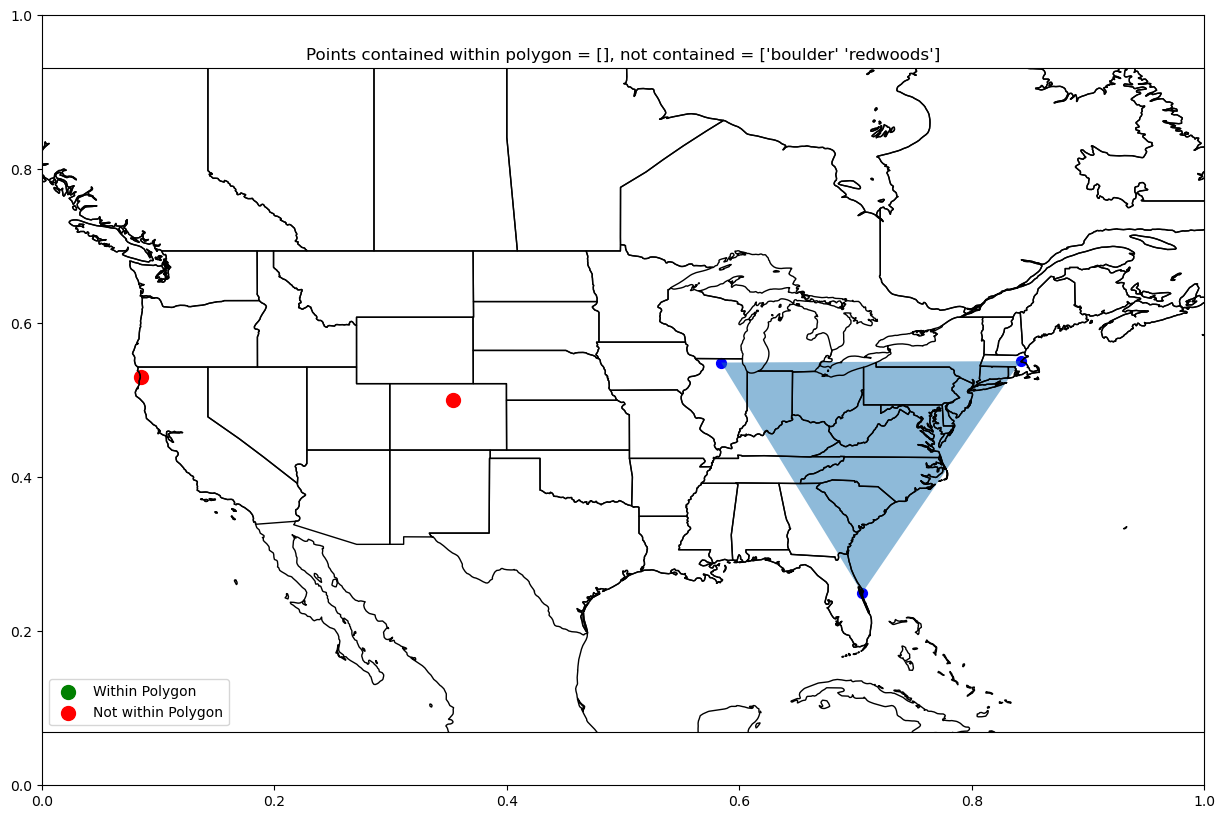

In [26]:
plot_polygon_pts(["boulder", "redwoods"], ["rockford", "boston", "cape canaveral"],
               -130, -60, 20, 60)

## Mean center of spherical polygon

A spherical polygon can have a fairly regular shape, especially as more points are added. But it is fairly simple using the `shapley` Python package to determine the mean center.

In [27]:
def polygon_centroid(polygon_pts=None):
    longitudes = [location_df.loc[x, "longitude"] for x in polygon_pts]
    latitudes = [location_df.loc[y, "latitude"] for y in polygon_pts]
    lat_lon_coords = tuple(zip(longitudes, latitudes))
    polygon = Polygon(lat_lon_coords)
    return (polygon.centroid.y, polygon.centroid.x)

In [26]:
polygon_centroid(["boulder", "boston", "houston"])

(37.30896666666666, -90.47586666666665)

### Plot Centroid

The center of a polygon can be fairly apparently on a map, let's give it a look!

In [27]:
def plot_centroid(polygon_pts=None,
                   lon_west=-180, lon_east=180,
                   lat_south=-90, lat_north=90):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.STATES, edgecolor="black")

   # plot polygon points
    longitudes = [location_df.loc[x, "longitude"] for x in polygon_pts] # longitude
    latitudes = [location_df.loc[y, "latitude"] for y in polygon_pts] # latitude
    plt.scatter(longitudes, latitudes, s=50, c="blue")
    plt.fill(longitudes, latitudes, alpha=0.5)

    # plot check point
    centeroid = polygon_centroid(polygon_pts)
    plt.scatter(centeroid[1], centeroid[0], s=100, c="red")
    plt.title(f"Centroid = {centeroid}")
    plt.show()

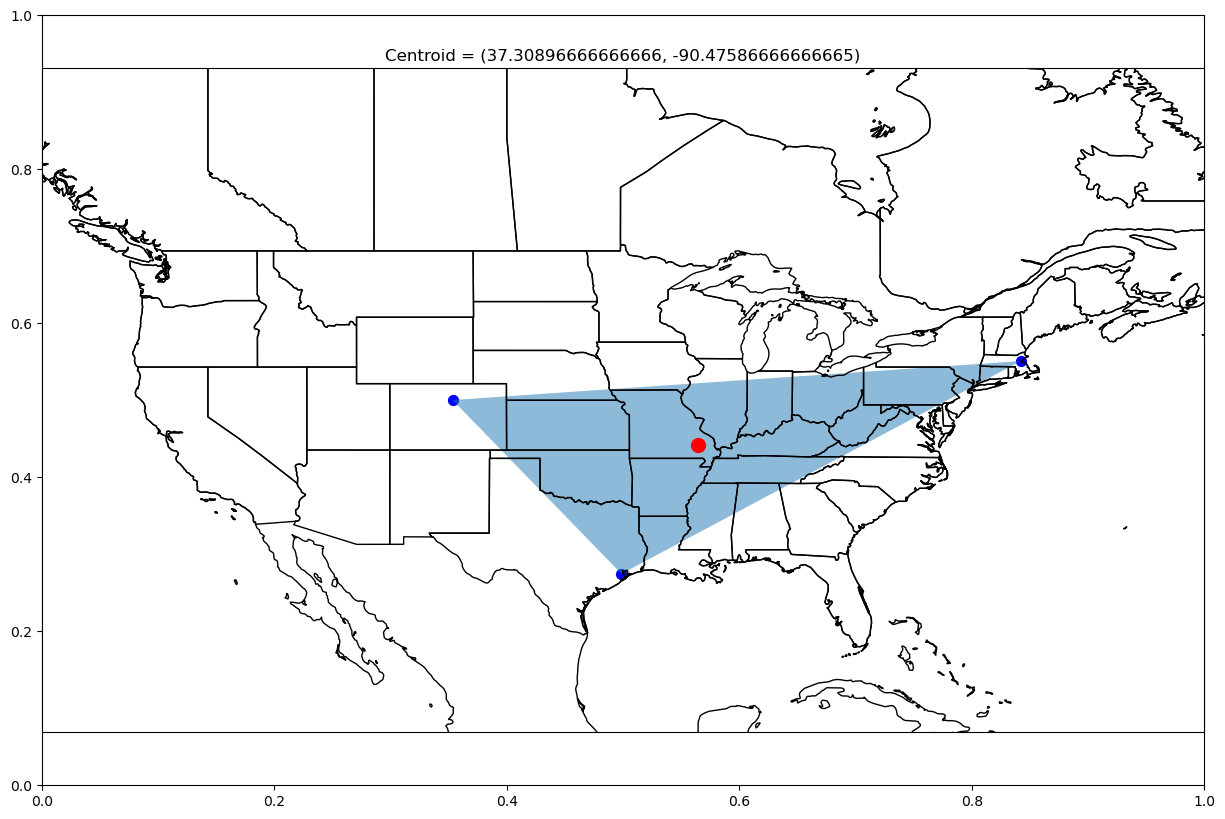

In [28]:
plot_centroid(["boulder", "boston", "houston"],
               -130, -60, 20, 60)

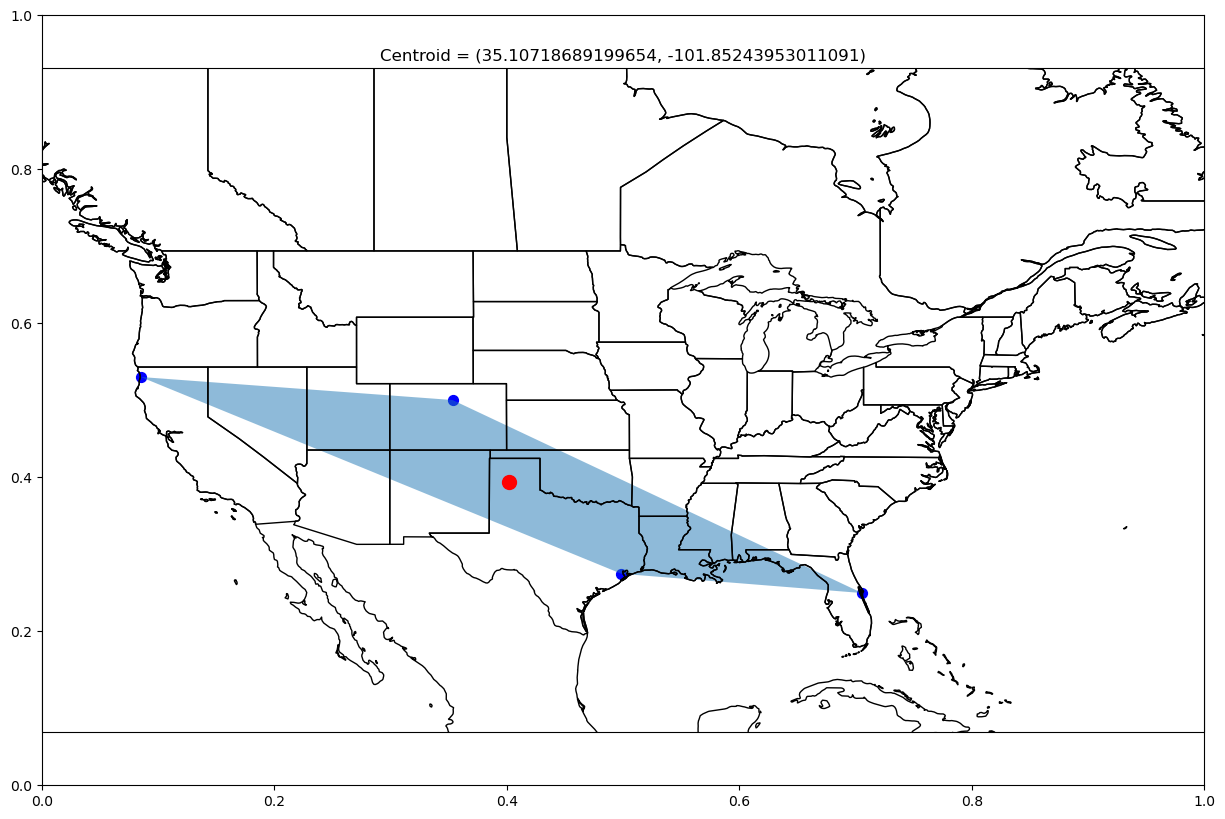

In [29]:
plot_centroid(["redwoods", "boulder", "cape canaveral", "houston"],
               -130, -60, 20, 60)

---

## Summary

This notebook covers working with spherical polygons to determine the ordering of coordinates, center of polygons, and whether or not a point lies within a spherical polygon

## Resources and references


- [Aviation Formulary V1.47](https://edwilliams.org/avform147.htm)
- [Moveable Type Script](https://www.movable-type.co.uk/scripts/latlong.html)